<a href="https://colab.research.google.com/github/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
# from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = "https://github.com/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/excel_dataset.xlsx?raw=true"
df = pd.read_excel(path)
df = df.dropna()
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.index = date_time
df.head()

,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH
Date Time,,,,,,,,,,,,
2009-01-01 00:10:00,0.428151,18.960609,3.973630,29.732470,0.014431,30711.65039,820.118210,632.399261,0.466357,1.444160,-5.616851,75.809700
2009-01-01 00:20:00,0.427783,18.960360,3.973562,30.123590,0.014822,30700.66016,819.662811,633.057602,0.475288,1.413894,-5.540349,75.810066
2009-01-01 00:30:00,0.427432,19.009649,4.181924,30.477831,0.012689,30689.66016,819.886444,631.841385,0.464559,1.515123,-5.628389,75.552841
2009-01-01 00:40:00,0.427082,19.155710,3.950392,30.425819,0.012580,30678.66016,819.660172,632.495224,0.471809,1.404055,-5.576591,75.580223
2009-01-01 00:50:00,0.426732,19.334640,3.689848,30.546061,0.012472,30667.66016,819.646805,632.388214,0.470504,1.191485,-5.274679,75.638023


In [ ]:
number_of_days = (df.shape[0]//144)+1 #// for integer division
number_of_extra_rows = df.shape[0]%144
df_days = df.rolling(144).mean().dropna()
df_days = df_days.iloc[::144,:]
df_extra = df[86*144:df.shape[0]].mean()
df_days = df_days.append(df_extra,ignore_index=True)
df_days

,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH
0,0.437426,18.989021,4.212129,32.006993,0.010173,30654.824301,830.488018,640.112469,0.469527,0.794234,-4.467693,75.694686
1,0.448062,18.809630,4.524849,33.836544,0.010565,30625.732653,844.455551,651.105717,0.469758,0.469703,-4.170596,75.561543
2,0.450353,19.083289,4.726570,34.668045,0.012945,30705.664307,852.964052,657.452192,0.470218,0.333544,-4.249914,75.352648
3,0.451834,18.531180,4.659772,34.896273,0.012922,30713.556058,854.393941,659.299923,0.469249,0.274911,-4.314996,75.919100
4,0.452508,17.260066,4.367844,34.849715,0.013748,30754.496406,854.443389,659.779801,0.469077,0.319588,-4.264858,77.543971
...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.516196,22.787623,4.144163,32.998388,0.012000,28634.796591,853.104591,651.138966,0.487782,0.976843,-4.962001,71.868771
83,0.516829,24.152432,4.141898,31.950313,0.012233,28754.501818,853.112442,650.101372,0.488156,1.030537,-4.959895,70.069474
84,0.517241,23.390510,4.132008,32.028396,0.012171,28687.527385,853.108998,651.155280,0.488213,1.037697,-4.961618,71.159993
85,0.517645,23.003283,4.141829,31.995858,0.012024,28685.423422,853.136709,651.738798,0.488620,0.917159,-4.959742,71.677207


In [ ]:
y_column = list()
y_column = [np.nan]
for i in df['CPRAVG'][:-1]:
  y_column.append(i)
y_column = np.array(y_column)

In [ ]:
df.insert(12,'Output',y_column)
df

,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH,Output
Date Time,,,,,,,,,,,,,
2009-01-01 00:10:00,0.428151,18.960609,3.973630,29.732470,0.014431,30711.65039,820.118210,632.399261,0.466357,1.444160,-5.616851,75.809700,NaN
2009-01-01 00:20:00,0.427783,18.960360,3.973562,30.123590,0.014822,30700.66016,819.662811,633.057602,0.475288,1.413894,-5.540349,75.810066,0.428151
2009-01-01 00:30:00,0.427432,19.009649,4.181924,30.477831,0.012689,30689.66016,819.886444,631.841385,0.464559,1.515123,-5.628389,75.552841,0.427783
2009-01-01 00:40:00,0.427082,19.155710,3.950392,30.425819,0.012580,30678.66016,819.660172,632.495224,0.471809,1.404055,-5.576591,75.580223,0.427432
2009-01-01 00:50:00,0.426732,19.334640,3.689848,30.546061,0.012472,30667.66016,819.646805,632.388214,0.470504,1.191485,-5.274679,75.638023,0.427082
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-03-28 13:20:00,0.516947,22.566521,4.234831,33.299759,0.012168,28546.11914,853.335480,653.310226,0.490392,0.977542,-4.964487,72.158081,0.517148
2009-03-28 13:30:00,0.516790,23.644880,4.081517,33.329700,0.011981,28570.01953,853.114197,652.723724,0.485867,0.982836,-4.957215,71.223877,0.516947
2009-03-28 13:40:00,0.516591,23.736650,4.371761,33.339199,0.011793,28593.91992,853.182159,653.046051,0.486376,0.988131,-4.961114,70.807220,0.516790


In [ ]:
df = df.dropna()

In [ ]:
df.head()

,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH,Output
Date Time,,,,,,,,,,,,,
2009-01-01 00:20:00,0.427783,18.960360,3.973562,30.123590,0.014822,30700.66016,819.662811,633.057602,0.475288,1.413894,-5.540349,75.810066,0.428151
2009-01-01 00:30:00,0.427432,19.009649,4.181924,30.477831,0.012689,30689.66016,819.886444,631.841385,0.464559,1.515123,-5.628389,75.552841,0.427783
2009-01-01 00:40:00,0.427082,19.155710,3.950392,30.425819,0.012580,30678.66016,819.660172,632.495224,0.471809,1.404055,-5.576591,75.580223,0.427432
2009-01-01 00:50:00,0.426732,19.334640,3.689848,30.546061,0.012472,30667.66016,819.646805,632.388214,0.470504,1.191485,-5.274679,75.638023,0.427082
2009-01-01 01:00:00,0.426381,19.491810,4.601716,30.532320,0.012364,30656.66992,819.507965,632.023209,0.467722,1.319569,-5.266271,74.667397,0.426732


In [ ]:
#Import ML libraries
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization,Activation,Add, Input
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam,SGD #Edit : from keras.optimizers import Adam #Does not work
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint

In [ ]:
numpy_df = df.to_numpy()
numpy_df

array([[ 0.42778286, 18.96035957,  3.973562  , ..., -5.54034901,
        75.81006622,  0.42815148],
       [ 0.42743246, 19.00964928,  4.18192387, ..., -5.62838888,
        75.55284119,  0.42778286],
       [ 0.42708208, 19.15571022,  3.95039201, ..., -5.57659101,
        75.58022308,  0.42743246],
       ...,
       [ 0.51659077, 23.73665047,  4.37176084, ..., -4.96111393,
        70.80722046,  0.51678994],
       [ 0.5163385 , 23.31922913,  4.15356111, ..., -4.9559021 ,
        71.45001984,  0.51659077],
       [ 0.51563475, 22.66431999,  4.08768797, ..., -4.96706009,
        72.16055298,  0.5163385 ]])

In [ ]:
n = len(numpy_df)
training_df = numpy_df[0:int(n*0.7)]
test_set = numpy_df[int(n*0.7):n]

In [ ]:
# data_X = numpy_df[:,0:12]
# data_Y = numpy_df[:,12]

In [ ]:
#Scaling the Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0,1))
df_for_training_scaled = scaler.fit_transform(training_df) #Scales and converts to numpy object
print('Scaled Dataset:\n',df_for_training_scaled)

Scaled Dataset:
 [[0.03834461 0.39139343 0.71841953 ... 0.09054363 0.69998058 0.04261512]
 [0.03428528 0.39611563 0.76908826 ... 0.05736476 0.68357295 0.03834461]
 [0.03022612 0.41010901 0.71278513 ... 0.0768854  0.68531957 0.03428528]
 ...
 [0.94817084 0.28810413 0.68416253 ... 0.51802072 0.79587724 0.94908733]
 [0.95048011 0.28807252 0.68538325 ... 0.51584291 0.79587529 0.94817084]
 [0.95188739 0.28809554 0.70426883 ... 0.51498322 0.79587237 0.95048011]]


In [ ]:
data_X = df_for_training_scaled[:,0:12]
data_Y = df_for_training_scaled[:,12]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Dense(100,activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(100,activation = 'relu'))
model.add(Dense(100,activation = 'relu'))
model.add(Dense(100,activation = 'relu'))
model.add(Dense(1,activation = 'relu'))
adam = Adam(learning_rate = 0.004)
model.compile(optimizer=adam,loss = 'mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 100)               1300      
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 31,701
Trainable params: 31,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,epochs=100,verbose=1,batch_size=10,validation_split=0.1)

Epoch 1/100
629/629 [==============================] - 2s 2ms/step - loss: 0.0036 - val_loss: 1.0156e-04
Epoch 2/100
629/629 [==============================] - 1s 2ms/step - loss: 2.0084e-04 - val_loss: 2.3206e-04
Epoch 3/100
629/629 [==============================] - 1s 2ms/step - loss: 2.1211e-04 - val_loss: 1.6319e-04
Epoch 4/100
629/629 [==============================] - 1s 2ms/step - loss: 1.4060e-04 - val_loss: 1.4026e-04
Epoch 5/100
629/629 [==============================] - 1s 2ms/step - loss: 1.9202e-04 - val_loss: 0.0012
Epoch 6/100
629/629 [==============================] - 1s 2ms/step - loss: 1.3918e-04 - val_loss: 6.5112e-05
Epoch 7/100
629/629 [==============================] - 1s 2ms/step - loss: 1.9057e-04 - val_loss: 3.1811e-04
Epoch 8/100
629/629 [==============================] - 1s 2ms/step - loss: 1.6844e-04 - val_loss: 3.7946e-05
Epoch 9/100
629/629 [==============================] - 1s 2ms/step - loss: 1.0175e-04 - val_loss: 4.8475e-04
Epoch 10/100
629/629 [=====

In [ ]:
predicted_CPRAVG = model.predict(X_test)

In [ ]:
test_df_scaled = scaler.transform(test_set)

In [ ]:
predicted_CPRAVG = np.repeat(predicted_CPRAVG,test_df_scaled.shape[1],axis = -1)
predicted_CPRAVG = scaler.inverse_transform(predicted_CPRAVG)[:,0]
predicted_CPRAVG = predicted_CPRAVG.reshape(-1,1)
predicted_CPRAVG

array([[0.46878052],
       [0.50254756],
       [0.49414966],
       ...,
       [0.4961232 ],
       [0.48264334],
       [0.45042974]], dtype=float32)

In [ ]:
y_test_original = np.repeat(y_test,X_test.shape[1],axis = -1)
y_test_original = scaler.inverse_transform(y_test_original)[:,0]
y_test_original = y_test_original.reshape(-1,1)
y_test_original

ValueError: ignored

In [ ]:
test_set[:,12]

array([0.50663901, 0.50621857, 0.50638215, ..., 0.51678994, 0.51659077,
       0.5163385 ])

In [ ]:
# xgboost
import xgboost
print("xgboost", xgboost.__version__)

xgboost 0.90


In [ ]:
# define model
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [ ]:
model.fit(data_X,data_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
predicted_CPRAVG = np.repeat(predicted_CPRAVG,test_df_scaled.shape[1],axis = -1)
predicted_CPRAVG = scaler.inverse_transform(predicted_CPRAVG)[:,0]
predicted_CPRAVG = predicted_CPRAVG.reshape(-1,1)
predicted_CPRAVG

In [ ]:
data_X_without_normalization = training_df[:,0:12]
data_Y_without_normalization = training_df[:,12]

In [ ]:
model.fit(data_X_without_normalization,data_Y_without_normalization)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
predictions = model.predict(test_set[:,0:12])

In [ ]:
predictions

array([0.5060243 , 0.5063834 , 0.5063834 , ..., 0.5099143 , 0.50991815,
       0.5099688 ], dtype=float32)

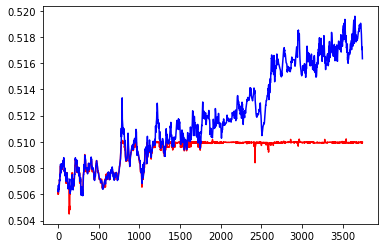

In [ ]:
predictions_original = test_set[:,12]
import matplotlib.pyplot as plt
plt.plot(predictions,color = 'red')
plt.plot(predictions_original, color = 'blue')